[20220924]

# 2. Model 8

After Preparation ready. Build and train the model in here. its using LSTM one layer. with data gen6

## Goal
Find patterns on the features for target

## Plan
Checklist what will be done on the notebook :

        [ ] Get Data
        [ ] Modelling
        [ ] Evaluation

In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
from statsmodels.tsa.arima.model import ARIMA
import sys
sys.path.insert(1,'../../src/')


In [2]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dropout, Flatten, Dense, Input, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics, optimizers
import keras
import tensorflow as tf
from keras.models import load_model

from sklearn.model_selection import train_test_split

In [3]:
with open("../../config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

PATH_RAW = config['path']['raw']
PATH_INTERIM = config['path']['interim']
PATH_PROCESSED = config['path']['processed']
# PATH_MODEL = config['path']['artifact']+os.getcwd().split('\\')[-1]+'/'
PATH_MODEL = config['path']['artifact']+'iteration_3'+'/'
PATH_UDF = config['path']['udf']

In [4]:
%matplotlib inline

## Get Data

In [5]:
Xt, Xt2, yt, Xo, Xo2, yo = joblib.load(PATH_INTERIM+'feat_target_gen6_iter3.pkl')
Xt = Xt.astype("float32")
Xt2 = Xt2.astype("float32")
yt = yt.astype("float32")

Xo = Xo.astype("float32")
Xo2 = Xo2.astype("float32")
yo = yo.astype("float32")

In [6]:
Xt.shape

(386396, 15, 3)

In [7]:
Xt2.shape

(386396, 2)

In [8]:
yt.shape

(386396, 1)

In [9]:
SEQ = Xt.shape[1]

In [10]:
## not the best way to split time series dataset
x_tr, x_test, x2_tr, x2_test, y_tr, y_test = train_test_split(
    Xt, Xt2, yt, test_size=0.25, random_state=42)

x_train, x_val, x2_train, x2_val, y_train, y_val = train_test_split(
    x_tr, x2_tr, y_tr, test_size=0.2, random_state=42)

In [11]:
# x2_tr.shape

## Model 8

In [12]:
# os.environ["CUDA_VISIBLE_DEVICES"] 

In [13]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
input1 = Input(shape=(SEQ,3))
x1 = LSTM(256, input_shape=(SEQ, 3), return_sequences=True)(input1)
x1 = LSTM(128, return_sequences=True)(x1)
x1 = LSTM(64)(x1)
x1 = Dense(32, activation='relu')(x1)
x1 = Dense(16, activation='relu')(x1)
x1 = Dense(8, activation='relu')(x1)
x1 = Dense(4, activation='relu')(x1)

input2 = Input(shape=(2,))
x2 = Dense(8, activation='relu')(input2)
x2 = Dense(4, activation='relu')(x2)

input = Concatenate()([x1, x2])
x = Dense(8, activation='relu')(input)
x = Dense(8, activation='relu')(x)
x = Dense(4, activation='linear')(x)
x = Dense(1, activation='linear')(x)
mod_ts = Model(inputs=[input1, input2], outputs=x)
mod_ts.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 3)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 15, 256)      266240      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 15, 128)      197120      lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 64)           49408       lstm_1[0][0]                     
_______________________________________________________________________________________

In [15]:
# tf.keras.utils.plot_model(mod_ts)

In [16]:
early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min', patience=6) 

check_p = keras.callbacks.ModelCheckpoint(
        filepath=PATH_MODEL+'ws_data_model8_iter3.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True)

opt = tf.keras.optimizers.Adam(learning_rate=0.00075)

mod_ts.compile(loss='mean_squared_error', optimizer=opt, metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='the_rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='the_mape'),
    ])

In [17]:
history = mod_ts.fit(
    [x_train,x2_train],
    y_train,
    batch_size=128,
    epochs=50,
    
    validation_data=([x_val,x2_val], y_val),
    callbacks=[early_stop,check_p]
)

Epoch 1/50
1812/1812 [==============================] - 34s 19ms/step - loss: 0.7125 - the_rmse: 0.8441 - the_mape: 157587.5000 - val_loss: 0.6039 - val_the_rmse: 0.7771 - val_the_mape: 99344.0156
Epoch 2/50
1812/1812 [==============================] - 33s 18ms/step - loss: 0.5404 - the_rmse: 0.7351 - the_mape: 140359.3125 - val_loss: 0.5388 - val_the_rmse: 0.7340 - val_the_mape: 160023.1406
Epoch 3/50
1812/1812 [==============================] - 34s 19ms/step - loss: 0.5024 - the_rmse: 0.7088 - the_mape: 112728.7344 - val_loss: 0.4918 - val_the_rmse: 0.7013 - val_the_mape: 171686.4219
Epoch 4/50
1812/1812 [==============================] - 34s 19ms/step - loss: 0.4851 - the_rmse: 0.6965 - the_mape: 100896.3750 - val_loss: 0.4787 - val_the_rmse: 0.6919 - val_the_mape: 77629.8594
Epoch 5/50
1812/1812 [==============================] - 34s 19ms/step - loss: 0.4729 - the_rmse: 0.6877 - the_mape: 89075.7891 - val_loss: 0.4723 - val_the_rmse: 0.6872 - val_the_mape: 135717.2344
Epoch 6/50
18

## Eval

<AxesSubplot:>

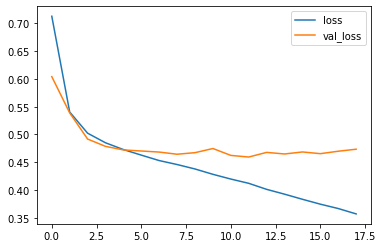

In [18]:
df_epoch_hist = pd.DataFrame(history.history)
df_epoch_hist[['loss','val_loss']].plot()

In [19]:
# depd = {'auc_1' : metrics.AUC}
model_load = load_model(PATH_MODEL + 'ws_data_model8_iter3.h5',compile=False)

In [20]:
model_load.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 3)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 15, 256)      266240      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 15, 128)      197120      lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 64)           49408       lstm_1[0][0]                     
_______________________________________________________________________________________

In [21]:
model_load.compile(loss='mean_squared_error', optimizer=opt, metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='the_rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='the_mape'),
    ])

In [22]:
model_load.evaluate([x_test,x2_test],y_test)

3019/3019 [==============================] - 21s 7ms/step - loss: 0.4683 - the_rmse: 0.6844 - the_mape: 91401.7266


[0.4683466851711273, 0.6843585968017578, 91401.7265625]

In [23]:
model_load.evaluate([Xo,Xo2],yo)

1250/1250 [==============================] - 7s 6ms/step - loss: 0.4337 - the_rmse: 0.6585 - the_mape: 104969.5625


[0.43367719650268555, 0.658541738986969, 104969.5625]